In [1]:
%run forward_dynamics_example.ipynb

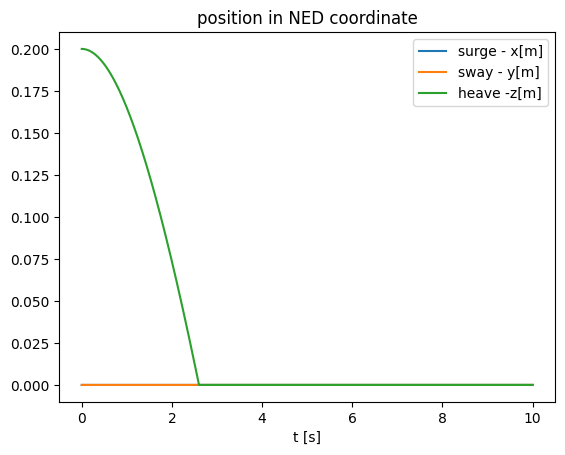

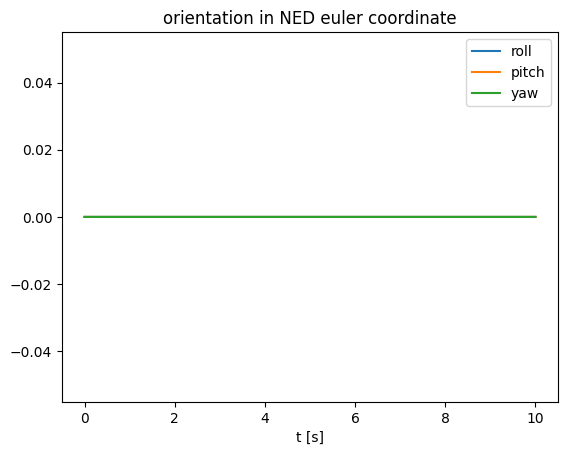

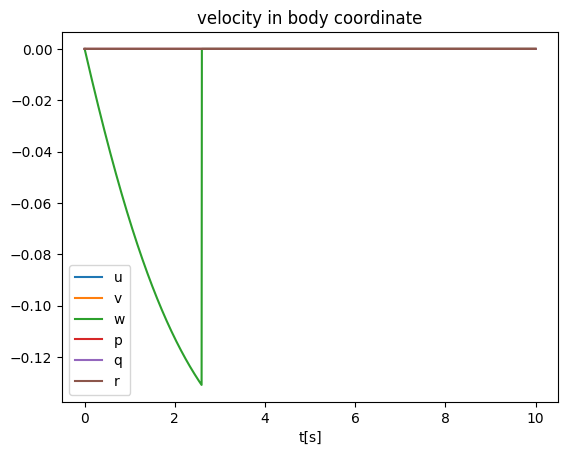

In [2]:
# SIMULATING vehicle on water surface
import matplotlib.pyplot as plt
sim = F.mapaccum(N)
x0 = np.array([0.0, 0.0, 0.2, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #x y z w xq yq zq u v w p q r
u0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
vc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
dt = T/N
res = sim(x0, u0, dt, vc)
res.T
t = np.linspace(0, T, N+1)


# Create a figure and plot the data
plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[0:3,:].T)
plt.legend(['surge - x[m]', 'sway - y[m]', 'heave -z[m]'])
plt.title("position in NED coordinate")
plt.xlabel('t [s]')

plt.figure()
vfunc = np.vectorize(euler_from_quaternion, signature='(n)->(k)')
rpy_array = vfunc(np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[3:7,:].T)
plt.plot(t, rpy_array)
plt.legend(['roll', 'pitch', 'yaw'])
plt.title("orientation in NED euler coordinate")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[7::,:].T)
plt.legend(['u', 'v', 'w', 'p', 'q', 'r'])
plt.xlabel('t[s]')
plt.title("velocity in body coordinate")
plt.show()